In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Any

import sys
import os

from meteostat import Point, Daily
from datetime import datetime

src_path = os.path.abspath(os.path.join(os.getcwd(), "..", "src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

from gratis_precip.features.base_features import *
from gratis_precip.features.precip_features import *


from gratis_precip.features import FeatureExtractor

import warnings

warnings.filterwarnings("ignore")

import logging

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

from gratis_precip.models import ARMAComponent, CompositeComponent, MARDataGenerator

from gratis_precip.dimensionality_reduction import PCAReduction, DimensionalityReducer

from gratis_precip.optimization import GARun

### Step 1: Fetch the target precipitation data

In [2]:

def fetch_precipitation_data():
    location = Point(47.368011576362896, 8.5387625442684280)  # Zurich
    start = datetime(1986, 1, 1)
    end = datetime(2023, 12, 31)
    data = Daily(location, start, end)
    data = data.fetch()
    return data['prcp']

target_data = fetch_precipitation_data()

### Step 2: Create the MAR model

In [3]:
def create_mar_model(data: pd.Series, n_components: int = 3):
    components = [
        ARMAComponent(order=(1, 1), weight=1/n_components),
        ARMAComponent(order=(2, 1), weight=1/n_components),
        ARMAComponent(order=(1, 2), weight=1/n_components)
    ]
    composite = CompositeComponent(components)
    mar_generator = MARDataGenerator(composite, steps=len(data))
    mar_generator.fit(data)
    return mar_generator

mar_model = create_mar_model(target_data)

### Step 3: Set up the feature extractor

In [16]:
feature_extractors = [
    TotalPrecipitation(),
    PrecipitationIntensity(),
    DrySpellDuration(),
    WetSpellDuration(),
    PrecipitationVariability(),
    ExtremePrecipitationFrequency(),
    MaximumDailyPrecipitation(),
    WetDayFrequency(),
    TrendFeature(),
    SeasonalStrengthFeature(),
    SpikeFeature(),
    LinearityFeature(),
]
feature_extractor = FeatureExtractor(feature_extractors)

### Step 4: Set up the dimensionality reducer

In [17]:
pca_reduction = PCAReduction(n_components=2)
dimensionality_reducer = DimensionalityReducer(pca_reduction)

### Step 5: Create and run the genetic algorithm

In [18]:
ga_run = GARun(
    mar_model=mar_model,
    feature_extractor=feature_extractor,
    dimensionality_reducer=dimensionality_reducer,
    target_time_series=target_data.values,
    num_generations=100,
    population_size=10,
    num_parents_mating=4
)

best_solution = ga_run.run()

2024-07-12 13:37:17,792 - INFO - Starting genetic algorithm run
2024-07-12 13:37:17,793 - INFO - Genetic algorithm initialized. Starting evolution.
2024-07-12 13:37:17,793 - INFO - Generating 1 trajectories...
2024-07-12 13:37:17,811 - INFO - Final generated trajectories:
2024-07-12 13:37:17,813 - INFO -               Sim_1
count  12979.000000
mean       1.893563
std        4.065165
min        0.000000
25%        0.602932
50%        1.233521
75%        2.191028
max      197.614721
2024-07-12 13:37:18,416 - INFO - Generating 1 trajectories...
2024-07-12 13:37:18,434 - INFO - Final generated trajectories:
2024-07-12 13:37:18,437 - INFO -               Sim_1
count  12915.000000
mean       1.838269
std        2.832164
min        0.000000
25%        0.662634
50%        1.252424
75%        2.161099
max       97.313885
2024-07-12 13:37:18,932 - INFO - Generating 1 trajectories...
2024-07-12 13:37:18,951 - INFO - Final generated trajectories:
2024-07-12 13:37:18,953 - INFO -               Sim_

### Step 6: Generate optimized time series

In [26]:
mar_model.update_weights(best_solution)
optimized_data = mar_model.generate(n_trajectories=6)

2024-07-12 13:45:44,873 - INFO - Generating 6 trajectories...
2024-07-12 13:45:45,002 - INFO - Final generated trajectories:
2024-07-12 13:45:45,008 - INFO -               Sim_1         Sim_2         Sim_3         Sim_4         Sim_5  \
count  12960.000000  12936.000000  12918.000000  12921.000000  12893.000000   
mean       1.821251      1.959443      1.875592      1.902139      1.867797   
std        2.799588      5.802011      3.579820      5.937989      2.918889   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.597549      0.602180      0.603511      0.599198      0.622512   
50%        1.199095      1.233368      1.229725      1.207346      1.219215   
75%        2.132897      2.176021      2.200073      2.148961      2.155746   
max       86.291265    412.955013    189.194766    549.476687     69.535641   

              Sim_6  
count  12929.000000  
mean       1.867754  
std        4.397355  
min        0.000000  
25%        0.598225 

In [27]:
optimized_data

,Sim_1,Sim_2,Sim_3,Sim_4,Sim_5,Sim_6
time,,,,,,
1986-01-01,NaN,0.449020,1.104150,0.820789,2.791465,1.422408
1986-01-02,1.326738,2.975065,2.736307,2.194046,4.217589,0.336894
1986-01-03,1.054537,4.113678,0.230319,1.185536,3.098399,0.572840
1986-01-04,3.114460,1.188353,1.694245,2.484515,1.409799,0.102239
1986-01-05,1.712959,3.796798,1.094545,3.259925,2.526229,1.928312
...,...,...,...,...,...,...
2023-12-27,2.100435,1.381297,1.245378,0.547749,0.537235,0.903511
2023-12-28,1.230209,1.237242,NaN,1.818242,1.991149,3.197272
2023-12-29,0.000000,0.330101,1.342730,2.388734,NaN,1.187414


### Step 7: Visualize results

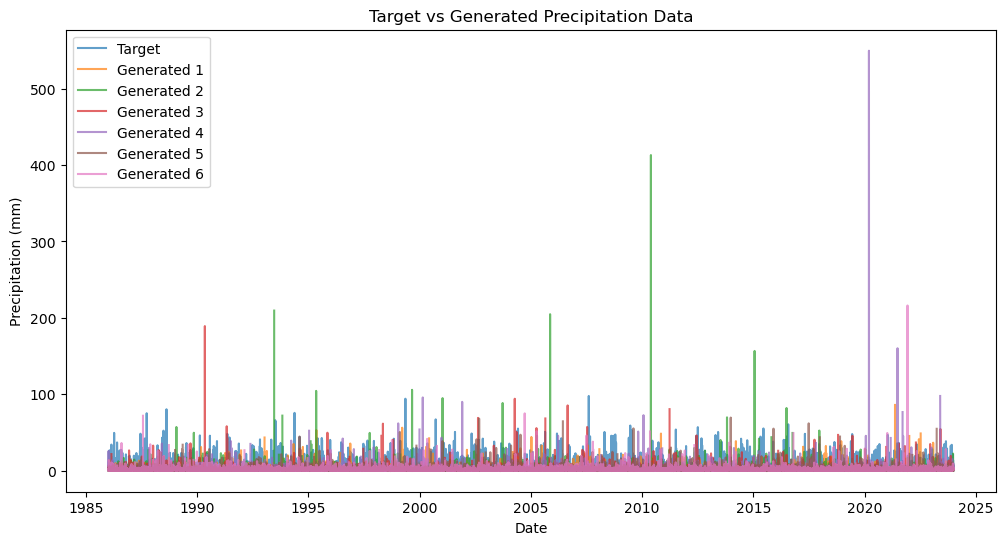

2024-07-12 22:13:50,840 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


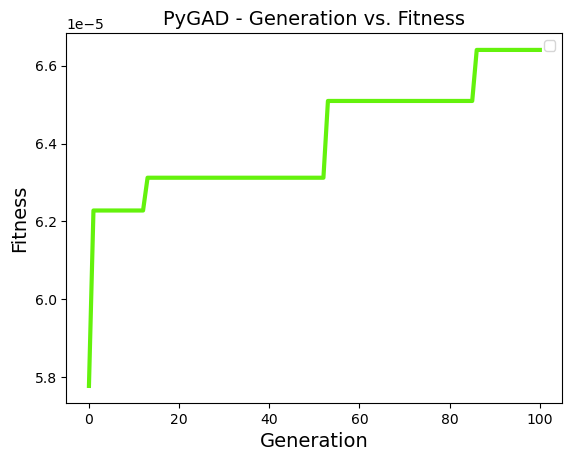

Target data statistics:
count    13879.000000
mean         3.049442
std          6.565659
min          0.000000
25%          0.000000
50%          0.000000
75%          3.150000
max         97.800000
Name: prcp, dtype: float64

Generated data statistics:
              Sim_1         Sim_2         Sim_3         Sim_4         Sim_5  \
count  12960.000000  12936.000000  12918.000000  12921.000000  12893.000000   
mean       1.821251      1.959443      1.875592      1.902139      1.867797   
std        2.799588      5.802011      3.579820      5.937989      2.918889   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.597549      0.602180      0.603511      0.599198      0.622512   
50%        1.199095      1.233368      1.229725      1.207346      1.219215   
75%        2.132897      2.176021      2.200073      2.148961      2.155746   
max       86.291265    412.955013    189.194766    549.476687     69.535641   

              Sim_6  
count  1292

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(target_data.index, target_data.values, label="Target", alpha=0.7)
for i in range(1, 7):
    plt.plot(
        target_data.index, optimized_data[f"Sim_{i}"], label=f"Generated {i}", alpha=0.7
    )
plt.legend()
plt.title("Target vs Generated Precipitation Data")
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.show()

# Optional: Plot fitness evolution
ga_run.plot_fitness_evolution()

# Print some statistics
print("Target data statistics:")
print(target_data.describe())
print("\nGenerated data statistics:")
print(optimized_data.describe())